In [96]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
np.random.seed(100)

4 Physical GPUs, 1 Logical GPU


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 250, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_108 (Conv1D)             (None, 250, 100)     300         input_43[0][0]                   
__________________________________________________________________________________________________
gru_35 (GRU)                    (None, 250, 128)     88320       conv1d_108[0][0]                 
__________________________________________________________________________________________________
conv1d_109 (Conv1D)             (None, 250, 100)     25700       gru_35[0][0]                     
____________________________________________________________________________________________

In [274]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
latent_dim = 50
base_window_size = 10
Fs = 25
n_timesteps = base_window_size*Fs
n_channels = 3

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



encoder_inputs = keras.Input(shape=(n_timesteps, n_channels))

x = layers.Conv1D(100, 20, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.GRU(128,return_sequences=True,activation='tanh')(x)
x = layers.Conv1D(100, 20, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(100, 30, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool1D(2)(x)
x = layers.Dropout(.5)(x)
x = layers.Conv1D(100, 30, activation="relu", strides=1, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(20, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(5*125, activation="relu")(latent_inputs)
x = layers.Reshape((125, 5))(x)
x = layers.Conv1DTranspose(125, 125, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv1DTranspose(125, 125, activation="relu", strides=2, padding="same")(x)
x = layers.GRU(10,return_sequences=True,activation='tanh')(x)
x = layers.Conv1D(100, 30, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling1D(2,strides=1,padding='same')(x)
x = layers.Conv1D(100, 30, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling1D(2,strides=1,padding='same')(x)
x = layers.Conv1D(100, 30, activation="relu", strides=1, padding="same")(x)
x = layers.AveragePooling1D(2,strides=1,padding='same')(x)
x = layers.GRU(n_channels,return_sequences=True,activation='tanh')(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, x, name="decoder")
# decoder = get_generator_model(latent_size=latent_dim)
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            aa = keras.losses.mean_absolute_error(data, reconstruction)
            reconstruction_loss = tf.reduce_sum(tf.reduce_mean(aa))
            print(reconstruction_loss.shape)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            total_loss = reconstruction_loss + kl_loss
#             + .1* kl_loss
#             + kl_loss
        print(total_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           [(None, 250, 3)]     0                                            
__________________________________________________________________________________________________
conv1d_164 (Conv1D)             (None, 250, 100)     6100        input_59[0][0]                   
__________________________________________________________________________________________________
gru_59 (GRU)                    (None, 250, 128)     88320       conv1d_164[0][0]                 
__________________________________________________________________________________________________
conv1d_165 (Conv1D)             (None, 250, 100)     256100      gru_59[0][0]                     
____________________________________________________________________________________________

In [275]:
import pickle
X,y = pickle.load(open('./data/10/walking_all_data1.p','rb'))

X = np.concatenate(X[:3])

X.shape

(3169, 250, 3)

In [276]:
X[X>2] = 2
X[X<-2] = -2


In [277]:
X = X/2

In [278]:
# X = X[:,:,:1]
X.shape

(3169, 250, 3)

In [279]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(X, epochs=300, batch_size=100)

Epoch 1/300
()
Tensor("add_1:0", shape=(), dtype=float32)
()
Tensor("add_1:0", shape=(), dtype=float32)
32/32 [==============================] - 5s 67ms/step - loss: 0.2386 - reconstruction_loss: 0.2293 - kl_loss: 3.0526e-04
Epoch 2/300
32/32 [==============================] - 2s 65ms/step - loss: 0.2206 - reconstruction_loss: 0.2221 - kl_loss: 2.5313e-06
Epoch 3/300
32/32 [==============================] - 2s 66ms/step - loss: 0.2204 - reconstruction_loss: 0.2209 - kl_loss: 4.1910e-07
Epoch 4/300
32/32 [==============================] - 2s 67ms/step - loss: 0.2194 - reconstruction_loss: 0.2211 - kl_loss: 3.8650e-07
Epoch 5/300
32/32 [==============================] - 2s 66ms/step - loss: 0.2204 - reconstruction_loss: 0.2205 - kl_loss: 2.7940e-07
Epoch 6/300
32/32 [==============================] - 2s 66ms/step - loss: 0.2220 - reconstruction_loss: 0.2203 - kl_loss: 3.3528e-07
Epoch 7/300
32/32 [==============================] - 2s 66ms/step - loss: 0.2233 - reconstruction_loss: 0.2208

KeyboardInterrupt: 

In [ ]:
z_sample = np.array([[xi, yi]])
x_decoded = vae.decoder.predict(z_sample)

In [262]:
z_sample = vae.encoder.predict(X[:10])[0]

In [263]:
z_sample.shape

(10, 50)

In [264]:
x_decoded = vae.decoder.predict(z_sample)

In [265]:
x_decoded.shape

(10, 250, 3)

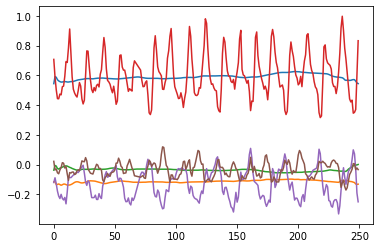

In [267]:
import matplotlib.pyplot as plt
plt.plot(x_decoded[8])
plt.plot(X[8])